In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to your data directories
train_dir = r"/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir = r"/kaggle/input/brain-tumor-mri-dataset/Testing"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4  # Update this based on the number of classes in your dataset

# Step 1: Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Step 2: Load Pretrained MobileNet Model
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',  # Pretrained on ImageNet
    include_top=False,   # Exclude the fully connected top layer
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze base model layers
base_model.trainable = False

# Step 3: Add Custom Classification Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dropout(0.5)(x)              # Dropout to reduce overfitting
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

# Step 4: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Set Up Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    'mobilenet_brain_tumor.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)


# Step 6: Train the Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.6409 - loss: 1.1061 - val_accuracy: 0.8673 - val_loss: 0.3745
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.8046 - loss: 0.5119 - val_accuracy: 0.8802 - val_loss: 0.3315
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.8186 - loss: 0.4731 - val_accuracy: 0.8551 - val_loss: 0.3704
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8319 - loss: 0.4248 - val_accuracy: 0.8551 - val_loss: 0.3566
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8421 - loss: 0.4196 - val_accuracy: 0.8688 - val_loss: 0.3500
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8474 - loss: 0.4020 - val_accuracy: 0.8924 - val_loss: 0.2960
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.8509 - loss: 0.3747 - val_accuracy: 0.8833 - val_loss: 0.3034
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.8601 - loss: 0.3631 - val_accuracy: 0.861

In [5]:
# Step 7: Evaluate the Model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 760ms/step - accuracy: 0.9263 - loss: 0.1962
Test Loss: 0.20464392006397247
Test Accuracy: 0.9252479076385498


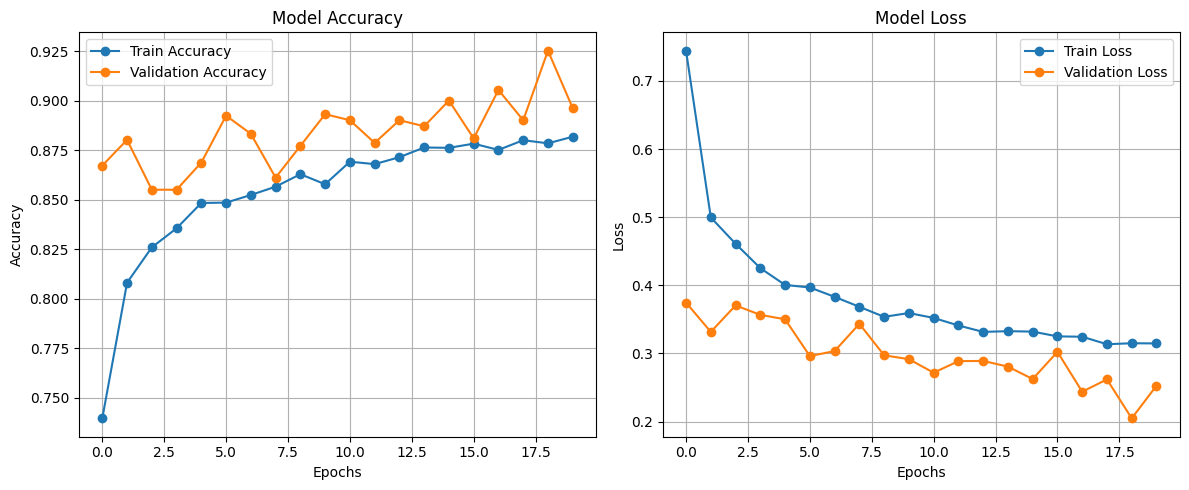

In [6]:
import matplotlib.pyplot as plt

# Plot Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [7]:
# Step 7: Unfreeze Specific Layers for Fine-Tuning
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Step 8: Compile with Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 9: Train the Model Again
fine_tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # Train for fewer epochs
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.7597 - loss: 0.8496 - val_accuracy: 0.8986 - val_loss: 0.3147
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8549 - loss: 0.4507 - val_accuracy: 0.9123 - val_loss: 0.2833
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.8683 - loss: 0.4039 - val_accuracy: 0.9214 - val_loss: 0.2463
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.8574 - loss: 0.3840 - val_accuracy: 0.9184 - val_loss: 0.2557
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.8855 - loss: 0.3322 - val_accuracy: 0.9222 - val_loss: 0.2336


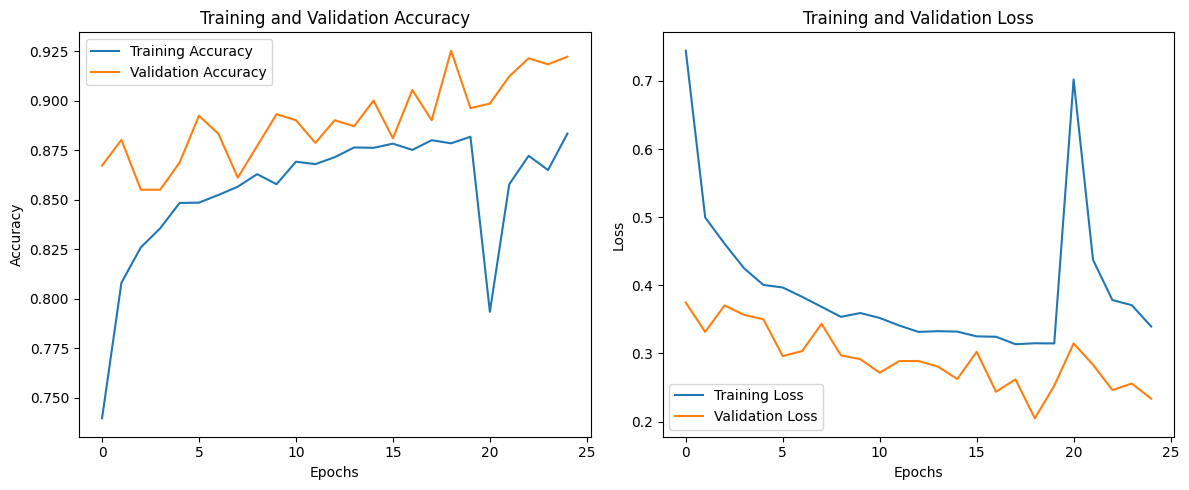

In [8]:
import matplotlib.pyplot as plt

# Combine the histories of initial training and fine-tuning
def plot_training_history(initial_history, fine_tune_history):
    # Extract metrics from initial training
    initial_acc = initial_history.history['accuracy']
    initial_val_acc = initial_history.history['val_accuracy']
    initial_loss = initial_history.history['loss']
    initial_val_loss = initial_history.history['val_loss']
    
    # Extract metrics from fine-tuning
    fine_tune_acc = fine_tune_history.history['accuracy']
    fine_tune_val_acc = fine_tune_history.history['val_accuracy']
    fine_tune_loss = fine_tune_history.history['loss']
    fine_tune_val_loss = fine_tune_history.history['val_loss']
    
    # Combine the metrics
    acc = initial_acc + fine_tune_acc
    val_acc = initial_val_acc + fine_tune_val_acc
    loss = initial_loss + fine_tune_loss
    val_loss = initial_val_loss + fine_tune_val_loss

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the two histories
plot_training_history(history, fine_tune_history)
